## Imoports and installs

In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.7 MB/s eta 0:00:00


In [9]:
import numpy as np
from pydicom import dcmread
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import convolve

## DICOM

In [3]:
def load_I(name):
  image = name
  dc = dcmread(image)
  print(dc)
  return dc.pixel_array

I=load_I("img.dcm")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.1055.1.20111103112244831.30826609.78057758
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.1055.1
(0002, 0013) Implementation Version Name         SH: 'dicomlibrary-100'
(0002, 0016) Source Application Entity Title     AE: 'DICOMLIBRARY'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 182
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'OTHER', 'ARC', 'DICOM', 'VALIDATION']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.1055

Adding some noise to the original image.

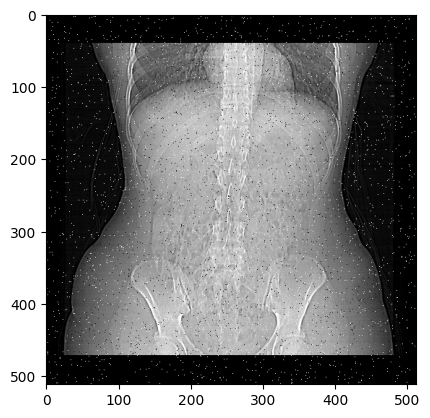

In [4]:
def add_salt_and_pepper_noise(image, noise_ratio=0.02):
    noisy_image = image.copy()
    h, w= noisy_image.shape
    noisy_pixels = int(h * w * noise_ratio)

    for _ in range(noisy_pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() < 0.5:
            noisy_image[row, col] = 0
        else:
            noisy_image[row, col] = 255

    return noisy_image

I=add_salt_and_pepper_noise(I)
plt.imshow(I, cmap="gray")
plt.show()

## Deniosing

### 1) denoising using frequency filters
Using low pass filter.

<ipython-input-5-c66cee560c54>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.uint8(im_back)


<Figure size 640x480 with 0 Axes>

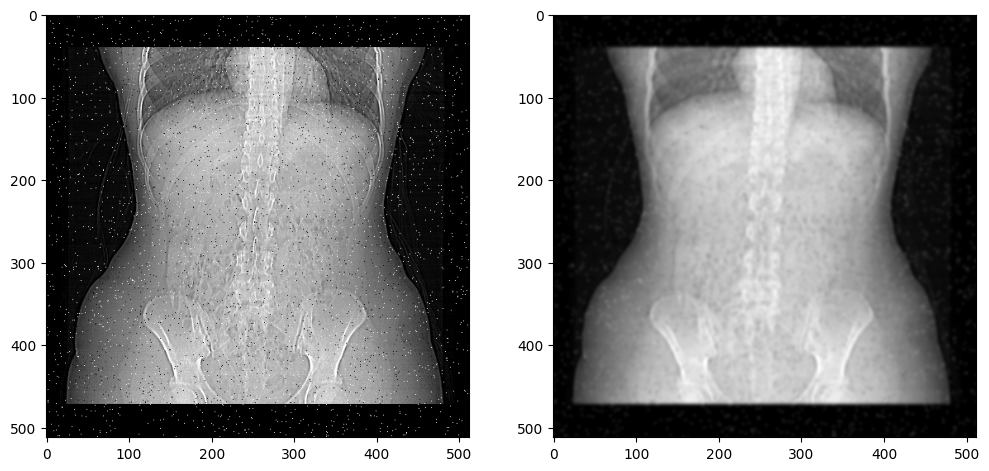

In [5]:
def low_pass(I):
  r = 15 # how narrow is our low pass filter
  han = np.hanning(I.shape[0]).reshape((-1, 1)) # using Hann window function
  han2d = np.sqrt(np.dot(han, han.T)) ** r # creating low pass filter

  dft = np.fft.fft2(np.float32(I))
  dft_shift = np.fft.fftshift(dft)
  amp = np.abs(dft_shift)
  phase = np.angle(dft_shift)

  new_amp = amp * han2d

  dft = new_amp * np.exp(1j*phase)
  dft_shift = np.fft.fftshift(dft)
  im_back = np.fft.ifft2(dft_shift)

  ### for filter plotting
  # plt.figure()
  # f, axarr = plt.subplots(1,3, figsize=(12, 12))
  # axarr[0].imshow(han2d, cmap='gray')
  # axarr[0].set_title('Low Pass Filter')
  # axarr[1].imshow(np.uint8(amp), cmap='gray')
  # axarr[1].set_title('Amplitude')
  # axarr[2].imshow(np.uint8(new_amp), cmap='gray')
  # axarr[2].set_title('Low Passed Amplitude')

  return np.uint8(im_back)

I_df=low_pass(I)
plt.figure()
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(I, cmap='gray')
axarr[1].imshow(I_df, cmap='gray')
plt.show()

### 2) denoising using spatial filters

<Figure size 640x480 with 0 Axes>

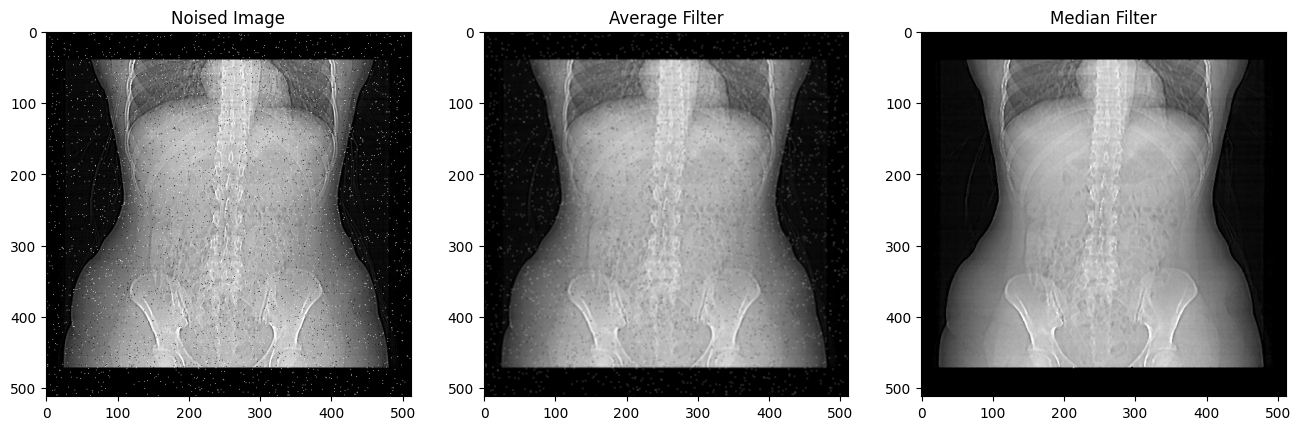

In [6]:
def denoise_spatial(I):
  im_avg = np.zeros(I.shape, dtype=np.float32)
  im_med = np.zeros(I.shape, dtype=np.float32)
  for i in range(1, I.shape[0]-1):
    for j in range(1, I.shape[0]-1):
      sub = [I[i-1][j-1], I[i-1][j], I[i-1][j+1], I[i][j-1], I[i][j], I[i][j+1], I[i+1][j-1], I[i+1][j], I[i+1][j+1]]
      avg = np.average(sub)
      median = np.median(sub)
      im_avg[i, j] = avg
      im_med[i, j] = median

  return np.uint8(im_avg), np.uint8(im_med)

I_ds1, I_ds2 = denoise_spatial(I)

plt.figure()
f, axarr = plt.subplots(1,3, figsize=(16, 10))
axarr[0].imshow(I, cmap='gray')
axarr[0].set_title('Noised Image')
axarr[1].imshow(I_ds1, cmap='gray')
axarr[1].set_title('Average Filter')
axarr[2].imshow(I_ds2, cmap='gray')
axarr[2].set_title('Median Filter')
plt.show()

### Discussion
From the plots above, we can conclude that the Spatial Filter (Median) produce the best results, seemingly completely removing the noise. Given the nature of s&p noise, both frequency filtering and average filtering do not perform well, leaving either too much noise or producing overly blurry results. On the other hand, median filtering performs effectively. Averaging alone cannot eliminate the noise because image noise contains extreme values (0 and 255), causing the average to be skewed by the noise, while the surrounding pixels have significantly different values. These extreme values do not significantly affect the median filter, unless the noise ratio is excessively high

In [7]:
I = I_ds2 # median denoised image

## Global Sharpening

Denoising images usualy result in less detailed blury images, therfore it is desirable to sharpen the denoised image.
for this means we have to amplify image details by first extracting them and then adding them to the image.

in this section we sharpen the image as described, once by using high pass filter and once by a spatial filter that can extract details (like edge detection filters).

### 1) sharpening using high pass filter
using low pass to generate a high pass image

<ipython-input-5-c66cee560c54>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.uint8(im_back)


<Figure size 640x480 with 0 Axes>

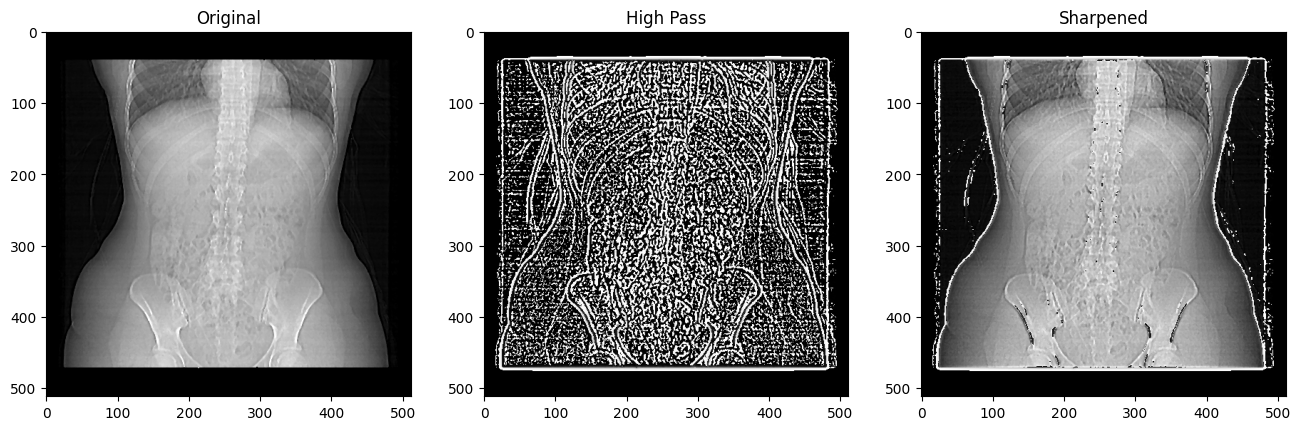

In [8]:
def high_pass(I):
  I_lp = low_pass(I)
  return np.uint8(I - I_lp)

detail_I = high_pass(I)
I_sharp_hi=I+detail_I

plt.figure()
f, axarr = plt.subplots(1,3, figsize=(16, 10))
axarr[0].imshow(I, cmap='gray')
axarr[0].set_title("Original")
axarr[1].imshow(detail_I, cmap='gray')
axarr[1].set_title("High Pass")
axarr[2].imshow(I_sharp_hi, cmap='gray')
axarr[2].set_title("Sharpened")
plt.show()

### 2) sharpening using a spatial filter
using edge detection filter.

<Figure size 640x480 with 0 Axes>

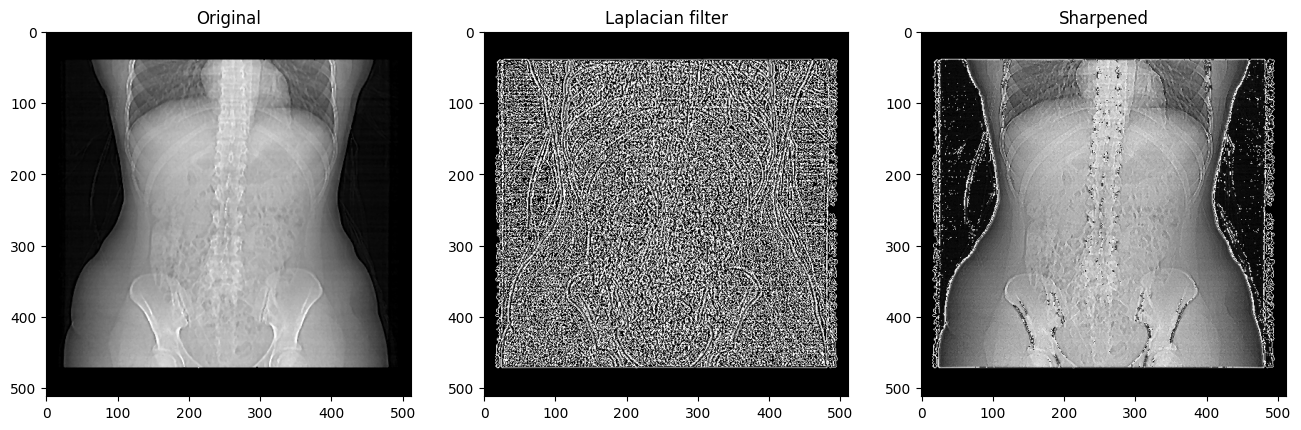

In [10]:
def detail_spatial(I):
  # ddepth = cv2.CV_32F
  filter = np.array([[0, -1, 0],
                     [-1, 4, -1],
                     [0, -1, 0]])
  dst = convolve(I, filter, mode='constant', cval=0.0)
  # dst = cv2.Laplacian(np.float32(I), ddepth, ksize=3)
  return np.uint8(dst)

detail_I = detail_spatial(I)
I_sharp_spatial=I+detail_I

plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(16, 10))
axarr[0].imshow(I, cmap='gray')
axarr[0].set_title("Original")
axarr[1].imshow(detail_I, cmap='gray')
axarr[1].set_title("Laplacian filter")
axarr[2].imshow(I_sharp_spatial, cmap='gray')
axarr[2].set_title("Sharpened")
plt.show()

## Multi-scale image enhancement

In this section multi-scale image enhancement is implemented; by pyramid of detail and add it to the original image level by level.

In [11]:
def multi_scaling(I, level):
  im_cp = I.copy()
  im_cp = np.float32(im_cp)
  D = []
  im = []
  while level > 0:
    down = cv2.pyrDown(im_cp)
    im.append(down)
    up = cv2.pyrUp(np.float32(down))
    D.append(im_cp - up)
    im_cp = down
    level -= 1

  return {'image': im, 'detail': D}


def rebuild_image(image_p, detail_p, factor):
  image = image_p[-1]
  for d in reversed(detail_p):
    im = cv2.resize(image, None, fx=factor, fy=factor)
    image = im + d

  return image

<Figure size 640x480 with 0 Axes>

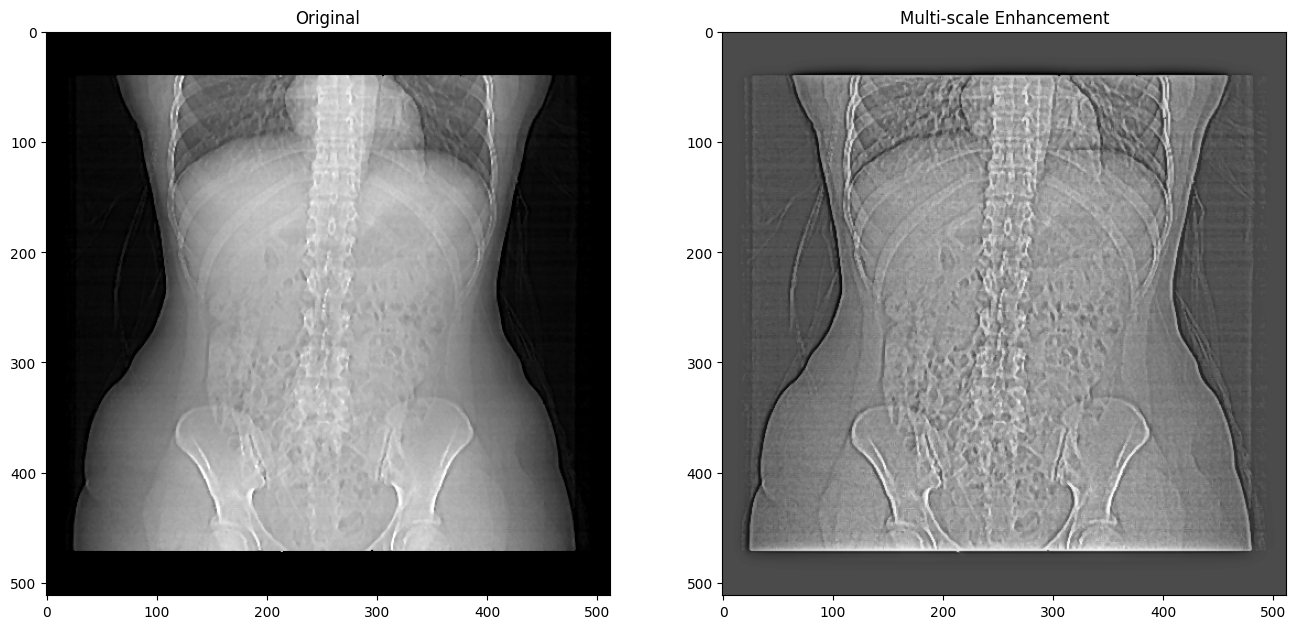

In [12]:
def multi_enhance(I, factor = 2):
  data = multi_scaling(I, 3)
  image = data['image']
  detail = data['detail']

  image.insert(0, I)
  for i in range(len(detail)):
    detail[i] = np.tanh(detail[i]/16) * max(np.max(detail[i]), np.abs(np.min(detail[i]))) # from MUSICA notebook (as global_enhancement())
  del image[0]

  image_rebuilt = rebuild_image(image, detail, 2)

  return image_rebuilt

I_e=multi_enhance(I)

plt.figure()
f, axarr = plt.subplots(1, 2, figsize=(16, 10))
axarr[0].imshow(I, cmap='gray')
axarr[0].set_title("Original")
axarr[1].imshow(I_e, cmap='gray')
axarr[1].set_title("Multi-scale Enhancement")
plt.show()

# I=I_e

## Gray level enhancment

<Figure size 640x480 with 0 Axes>

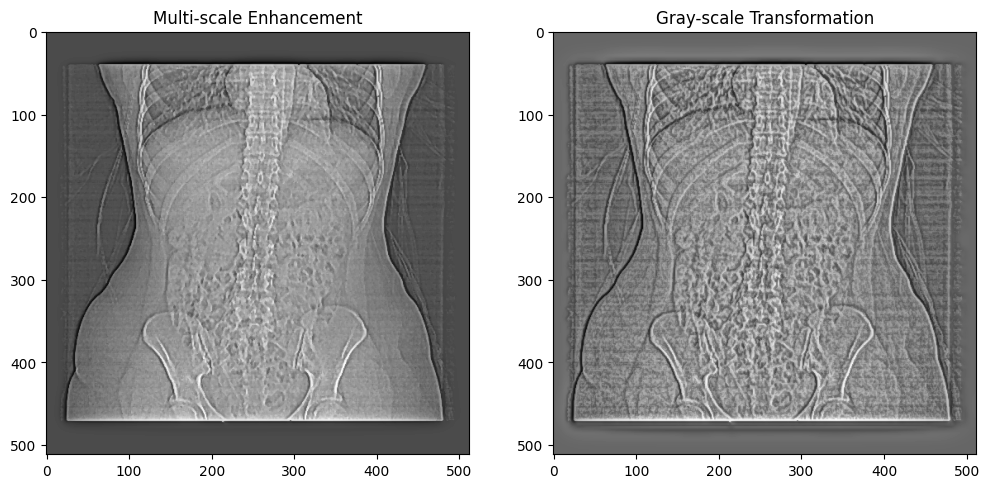

In [14]:
def scale(x):
  pos = np.where(x < 0, 0, x)
  neg = np.where(x > 0, 0, x)

  pos = 15.9 * np.sqrt(pos)
  neg = -15.9 * np.sqrt(-neg)

  return pos + neg


def gray_enhance(I):
  data = multi_scaling(I, 3)
  detail = data['detail']
  image = data['image']
  for i in range(len(detail)):
    detail[i] = scale(detail[i])

  return rebuild_image(image, detail, 2)

I_c = gray_enhance(I_e)

plt.figure()
f, axarr = plt.subplots(1,2, figsize=(12, 8))
axarr[0].imshow(I_e, cmap='gray')
axarr[0].set_title("Multi-scale Enhancement")
axarr[1].imshow(I_c, cmap='gray')
axarr[1].set_title("Gray-scale Transformation")
plt.show()